In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Consider 
\begin{equation}
f(x) = e^{\cos^{-1}x}, \int f(x)dx = 
\left\{
t=\cos^{-1}x, \; x=\cos t, \; dx = -\sin(t) dt
\right \} =
\int e^{t}(\sin(t) dt)=-\int e^{t} \sin(t) dt = \newline
= -\frac{1}{2}\left(\int e^{t} \sin(t) dt + \int e^{t} \sin(t) dt\right)=
\begin{vmatrix} 
e^t = u     & \sin(t) dt = dv  \newline
e^t dt = du & -\cos(t) = v  \newline
\end{vmatrix}, \quad
\begin{vmatrix} 
\sin(t) dt = u & e^t = dv   \newline
-\cos(t) = du  & e^t dt = v  \newline
\end{vmatrix} = \newline
= -\frac{1}{2}\left(-e^t \cos(t)+\int e^{t} \cos(t) dt +e^t \sin(t)-\int e^{t} \cos(t) dt\right)=
\frac{1}{2}\left(x-\sqrt{1-x^2}\right)e^{\cos^{-1}x}+C;
\end{equation}

\begin{equation}
\int_{-1}^{1} f(x)dx = \frac{1}{2}(1+e^\pi)\approx 12.07
\end{equation}

In [2]:
def f(x):
    return np.exp(np.arccos(x))

def f_int(x):
    return (x - np.sqrt(1 - x**2)) * f(x) / 2

In [3]:
f_int(1) - f_int(-1)

12.070346316389633

In [4]:
def integrate(f, limits, step):
    """
    Compute function integral by using trapezoid rule.
        f: function to integrate
        limits: ends of a segment over which we wish to integrate
        steps: # of discretization steps
    """
    x = np.linspace(limits[0], limits[1], step)
    f_x = f(x)
    result = (f_x[0] + f_x.sum() * 2 + f_x[-1]) * 0.5 * (x[1] - x[0])
    return result

In [5]:
integrate(f, [-1, 1], 10**7)

12.070351144492978

In [6]:
steps = np.arange(10, 1e+5 + 10, 10, dtype=np.int32)
limits = [-1, 1]
s = f_int(limits[1]) - f_int(limits[0])
errors = []
for step in steps:
    s_hat = integrate(f, limits, step)
    errors.append(np.abs(s - s_hat))
errors = np.array(errors)

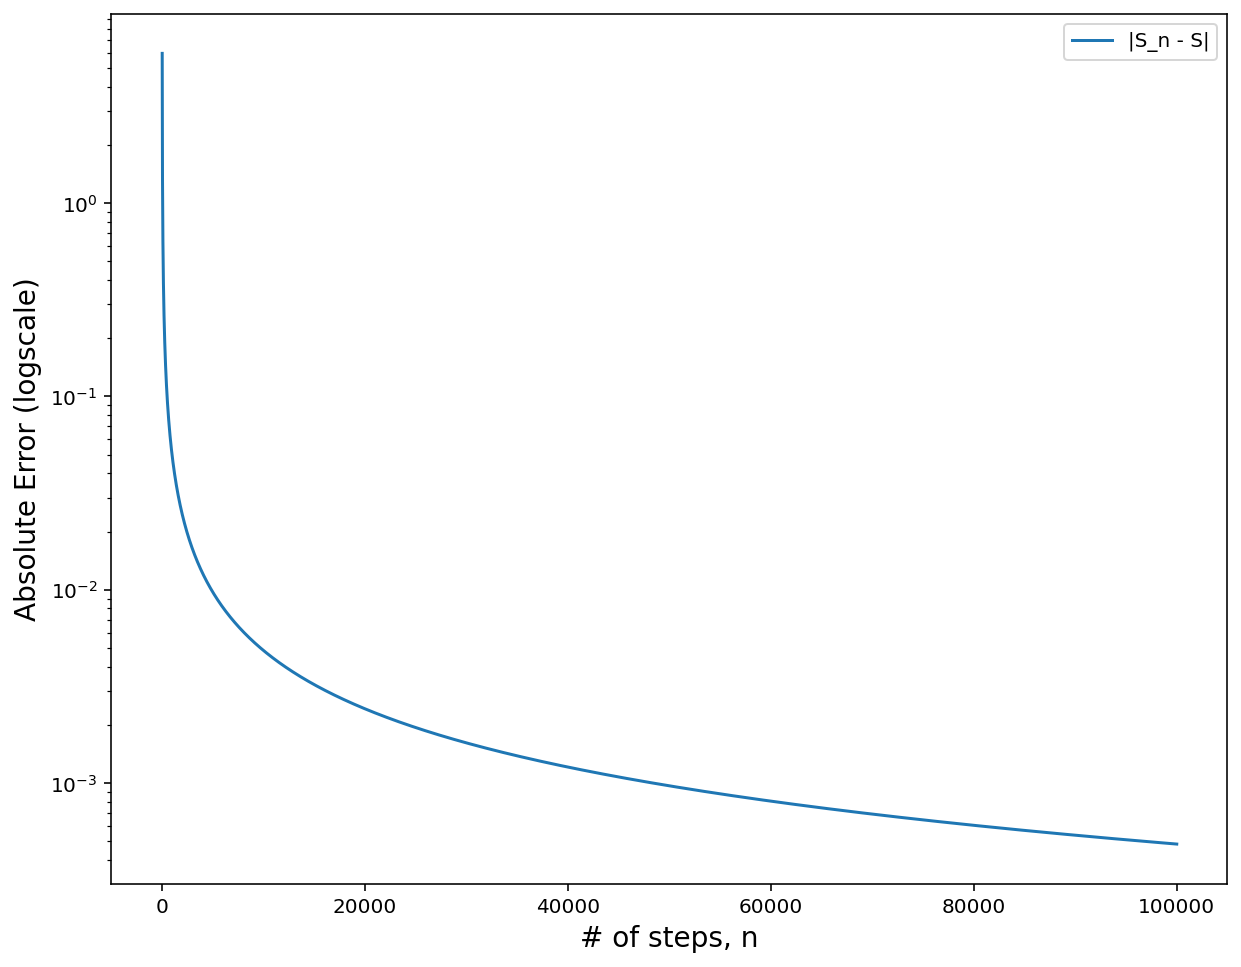

In [7]:
plt.figure(figsize=(10,8))
plt.semilogy(steps, errors, label="|S_n - S|")   
plt.xlabel("# of steps, n", fontsize=14)
plt.ylabel("Absolute Error (logscale)", fontsize=14)
plt.legend()
plt.show()

The integral value definetely converges to the true value as we take more discretization points.

In [8]:
%%writefile integral.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import argparse

def f(x):
    return np.exp(np.arccos(x))

def f_int(x):
    return (x - np.sqrt(1 - x**2)) * f(x) / 2

def integrate(f, limits, step):
    """
    Compute function integral by using trapezoid rule.
        f: function to integrate
        limits: ends of a segment over which we wish to integrate
        steps: # of discretization steps
    """
    x = np.linspace(limits[0], limits[1], step)
    f_x = f(x)
    result = (f_x[0] + f_x.sum() * 2 + f_x[-1]) * 0.5 * (x[1] - x[0])
    return result

def main(steps=1e+5):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    all_nodes = np.linspace(-1, 1, num=size + 1)
    s = integrate(f, limits=all_nodes[rank: rank + 2], step = steps // size)
    comm.Barrier()

    s = comm.gather(s, root=0)

    if rank == 0:
        return sum(s)

if __name__ == '__main__':
    parser = argparse.ArgumentParser("Task 7")
    parser.add_argument("-steps",  help="# of discretization steps", type=int)
    args = parser.parse_args()
    main(args.steps)


Overwriting integral.py


Curious thing! Up to `steps = 1e+8` there is no speedup achieved. In fact, calculations get even slower.

In [9]:
times = []
for i in range(1, 13):
    time_parallel = %timeit -o -q !mpirun -n {i} python3 integral.py -steps 10000000
    times.append(time_parallel.average)
    print(f"# of processors: {i}: time: {time_parallel.average}")

# of processors: 1: time: 0.6540935505763628
# of processors: 2: time: 0.6524344375710436
# of processors: 3: time: 0.6470169672850586
# of processors: 4: time: 0.6777776915717239
# of processors: 5: time: 0.7052897338601595
# of processors: 6: time: 0.7419173675734783
# of processors: 7: time: 0.7698875032843456
# of processors: 8: time: 0.8231300922863218
# of processors: 9: time: 0.8483159901412104
# of processors: 10: time: 0.8830732277128845
# of processors: 11: time: 0.9211293002860786
# of processors: 12: time: 0.9418832757115264


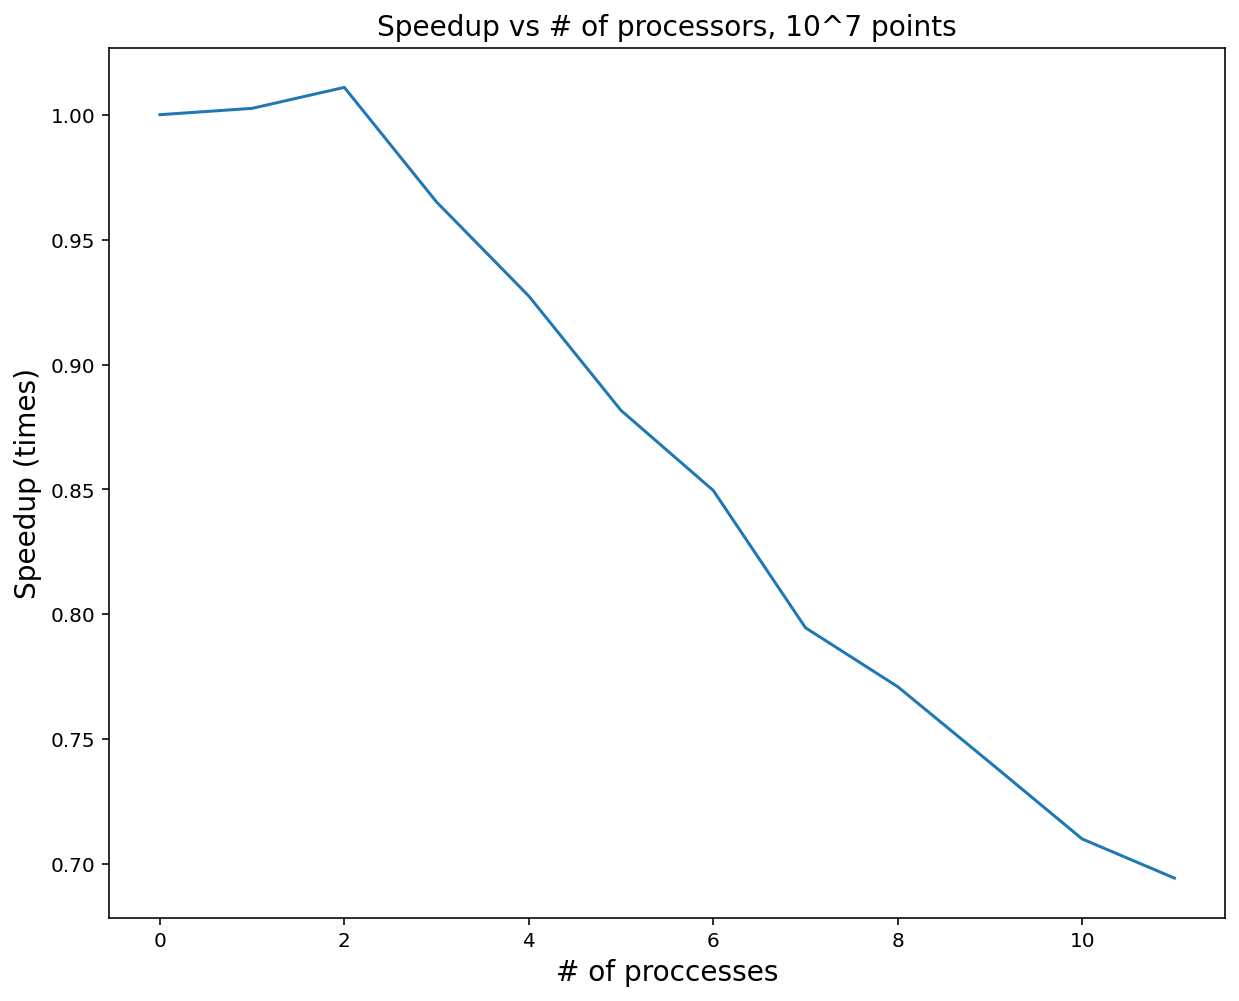

In [10]:
times = np.array(times)
speedup = times[0] / times
plt.figure(figsize=(10,8))
plt.plot(speedup)
plt.title("Speedup vs # of processors, 10^7 points", fontsize=14)
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Speedup (times)", fontsize=14)
plt.show()

In [11]:
times = []
for i in range(1, 13):
    time_parallel = %timeit -o -q !mpirun -n {i} python3 integral.py -steps 100000000
    times.append(time_parallel.average)
    print(f"# of processors: {i}: time: {time_parallel.average}")

# of processors: 1: time: 2.096619274716691
# of processors: 2: time: 1.416288333572863
# of processors: 3: time: 1.235229690147597
# of processors: 4: time: 1.1369469707133248
# of processors: 5: time: 1.1415185129964291
# of processors: 6: time: 1.1419128978575048
# of processors: 7: time: 1.212450718571615
# of processors: 8: time: 1.2098813409975264
# of processors: 9: time: 1.2516493115732115
# of processors: 10: time: 1.2675922890027453
# of processors: 11: time: 1.2831908440005333
# of processors: 12: time: 1.3077905411420423


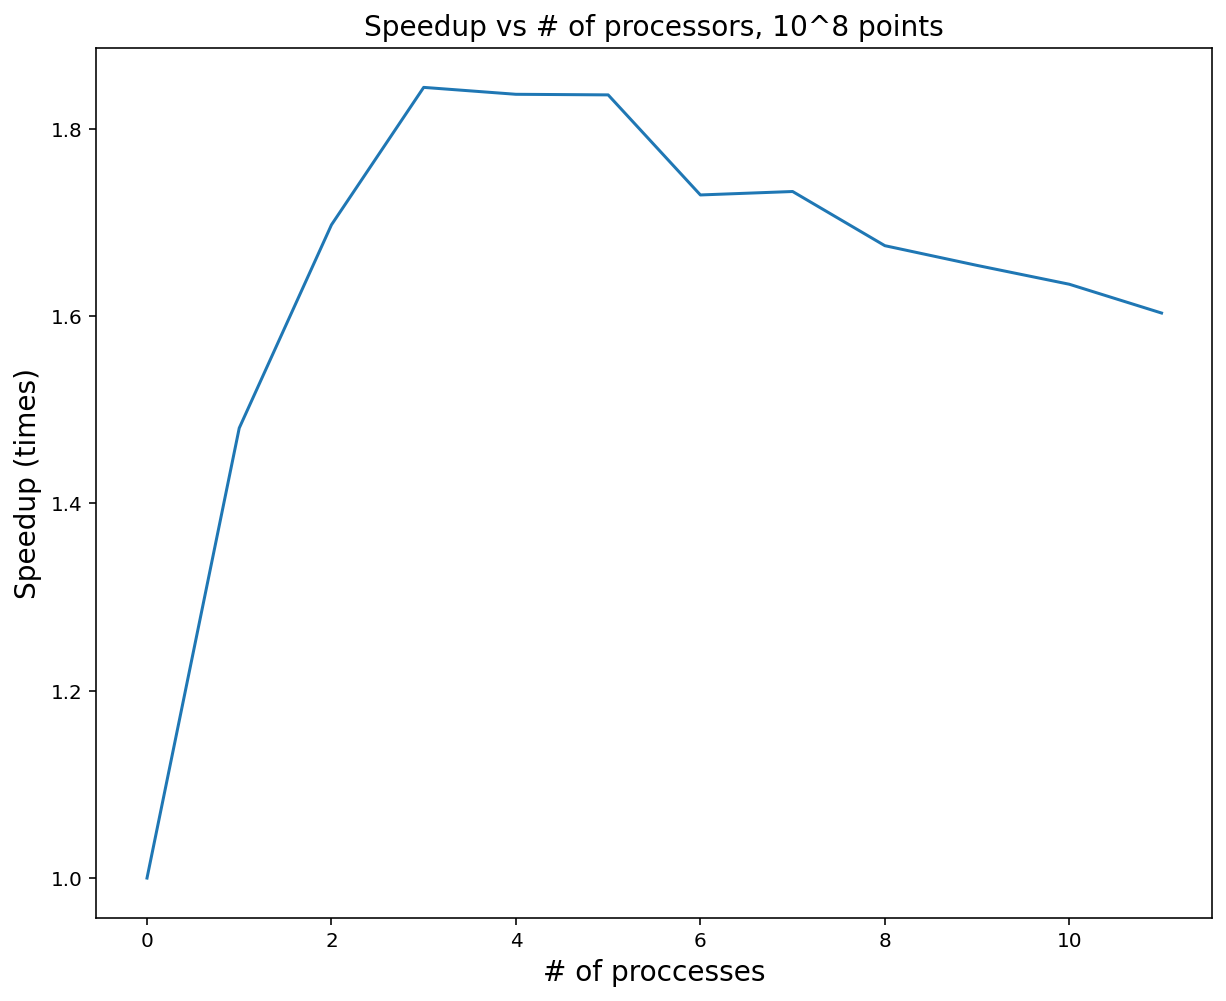

In [12]:
times = np.array(times)
speedup = times[0] / times
plt.figure(figsize=(10,8))
plt.plot(speedup)
plt.title("Speedup vs # of processors, 10^8 points", fontsize=14)
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Speedup (times)", fontsize=14)
plt.show()

In [13]:
times = []
for i in range(1, 13):
    time_parallel = %timeit -o -q !mpirun -n {i} python3 integral.py -steps 500000000
    times.append(time_parallel.average)
    print(f"# of processors: {i}: time: {time_parallel.average}")

# of processors: 1: time: 8.509385406713202
# of processors: 2: time: 4.858118481428911
# of processors: 3: time: 3.8045541042832025
# of processors: 4: time: 3.2421917187124825
# of processors: 5: time: 2.9276997451441793
# of processors: 6: time: 2.7783333605724954
# of processors: 7: time: 2.7344601057162174
# of processors: 8: time: 2.7564527037133564
# of processors: 9: time: 3.006884433283371
# of processors: 10: time: 2.944286658430688
# of processors: 11: time: 2.9270192892831153
# of processors: 12: time: 2.916746775145709


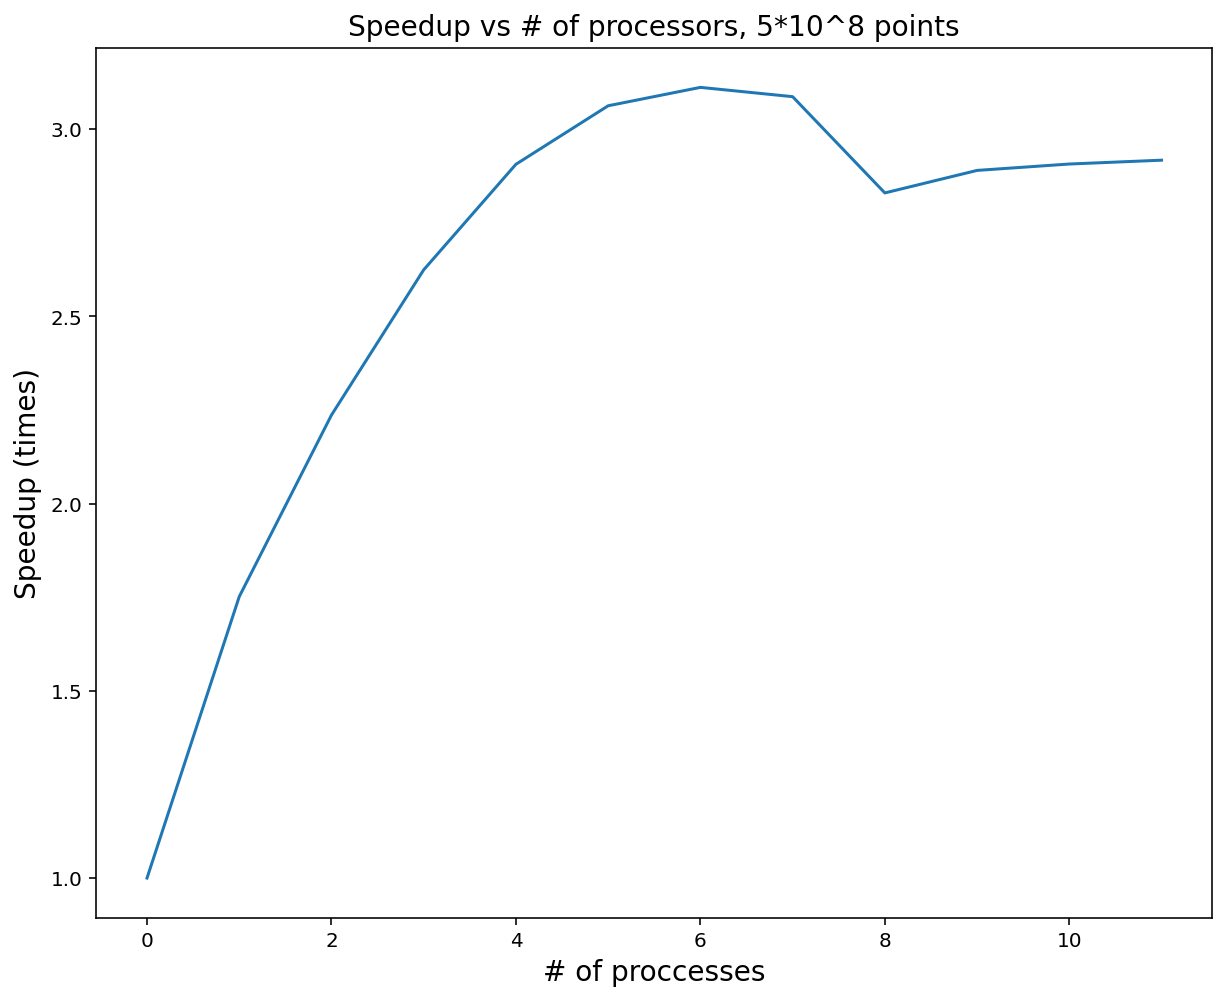

In [14]:
times = np.array(times)
speedup = times[0] / times
plt.figure(figsize=(10,8))
plt.plot(speedup)
plt.title("Speedup vs # of processors, 5*10^8 points", fontsize=14)
plt.xlabel("# of proccesses", fontsize=14)
plt.ylabel("Speedup (times)", fontsize=14)
plt.show()

Overall observation the more points we have, the more significant is the speedup. We also observe saturation at around 7 processes on my CPU.